In [2]:
import pandas as pd 

from sklearn.linear_model import LinearRegression

from utils import create_time_series_splits

In [3]:
df = pd.read_csv('./preprocessed_data.csv', sep=',', parse_dates=['Datetime'], index_col=0)
df.index = pd.to_datetime(df['Datetime'], utc=True)
df.drop(columns=['Datetime'], inplace=True)
df.dropna(inplace=True)
to_remove = list(set(df.columns).difference({'Total Load', 'Most recent forecast','Day-ahead 6PM P10'}))

In [4]:
excluded_columns = ['Total Load', 'Most recent forecast', 'Most recent P10',
       'Most recent P90', 'Day-ahead 6PM forecast', 'Day-ahead 6PM P10',
       'Day-ahead 6PM P90', 'Week-ahead forecast', 'Year', 'Month', 'Day',
       'Hour', 'Minute', 'Season', 'Lockdown']

In [14]:
splits = create_time_series_splits(
    data=df,
    train_size_days=7*4, # 1 month for training (all times)
    test_size_days=7*4, # 1 month for testing (only at 6pm)
    num_splits=10,
    window_size_steps=4*24*2, # 6 hours window
    exclude_columns=excluded_columns,
    target_column='Total Load Interpolated',
    prediction_horizon_steps=4*30, # 30 hours step ahead forecast
    shifting_steps=1,
    elia_column_to_return='Day-ahead 6PM forecast',
    alignment_times=['18:00']
)

100%|██████████| 2688/2688 [00:00<00:00, 29232.92it/s]


In [15]:
split_idx = 3
X_train = splits[split_idx]['X_train']
Y_train = splits[split_idx]['Y_train']
X_test = splits[split_idx]['X_test']
Y_test = splits[split_idx]['Y_test']
ELIA_train = splits[split_idx]['ELIA_train']
ELIA_test = splits[split_idx]['ELIA_test']

In [16]:
X_train.shape, Y_test.shape

((2688, 192), (28, 120))

In [17]:
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [18]:
Y_pred

array([[8398.78704483, 8332.40291272, 8251.64266814, ..., 8168.28473793,
        8073.10034651, 8038.2278125 ],
       [8012.58680925, 8009.62477444, 7953.38833233, ..., 8840.13636588,
        8765.63254615, 8692.11464586],
       [8722.39830421, 8666.98176488, 8625.16810838, ..., 9145.5003427 ,
        9086.65783639, 9034.70866048],
       ...,
       [9482.81406336, 9420.77503698, 9368.90492954, ..., 7964.95001267,
        7876.82081863, 7824.08592956],
       [9843.82105268, 9763.85594271, 9686.48554763, ..., 8185.5063771 ,
        8103.48481091, 8053.04192348],
       [9178.23227762, 9099.6640596 , 9034.81727671, ..., 7903.97134843,
        7832.19755993, 7790.18877897]])

In [19]:
# column wise MAPE 
mape_linear = (abs(Y_pred - Y_test.values) / Y_test.values)

In [20]:
ELIA_test.columns = Y_test.columns

In [21]:
# column wise MAPE 
mape_elia = (abs(ELIA_test.values - Y_test.values) / Y_test.values)

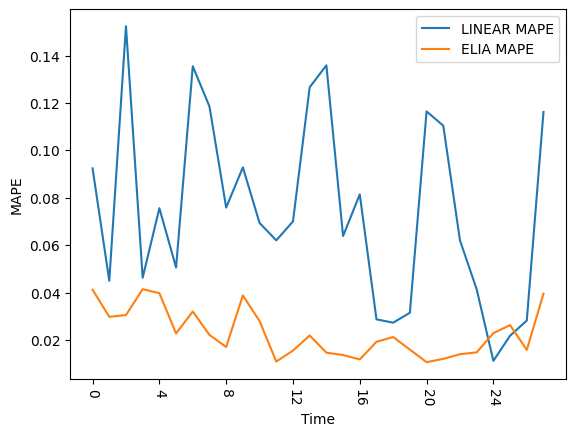

In [22]:
# plot mape 
import matplotlib.pyplot as plt
plt.plot(mape_linear.mean(axis=1), label='LINEAR MAPE')
plt.plot(mape_elia.mean(axis=1), label='ELIA MAPE')
plt.xlabel('Time')
plt.xticks(range(0, len(mape_linear.mean(axis=1)), 4))
plt.xticks(rotation=-90)
plt.ylabel('MAPE')
plt.legend()